In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eeg-in/A08T.gdf
/kaggle/input/eeg-in/Channelwise Saclogram stacked.py


In [2]:
!pip install mne

In [3]:
import mne
# from ssqueezepy import cwt
# from ssqueezepy.visuals import plot ,imshow
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import pywt
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from sklearn.model_selection import ShuffleSplit
from keras.utils import to_categorical
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import MinMaxScaler


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
raw = mne.io.read_raw_gdf('/kaggle/input/eeg-in/A08T.gdf')


Extracting EDF parameters from /kaggle/input/eeg-in/A08T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


In [5]:
events, a= mne.events_from_annotations(raw)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


In [6]:
raw.load_data()

Reading 0 ... 675269  =      0.000 ...  2701.076 secs...


<RawGDF | A08T.gdf, 25 x 675270 (2701.1 s), ~128.8 MB, data loaded>

In [7]:
raw.filter(8., 13., fir_design='firwin')


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 413 samples (1.652 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.6s finished


<RawGDF | A08T.gdf, 25 x 675270 (2701.1 s), ~128.8 MB, data loaded>

In [8]:
raw.info['bads'] += ['EOG-left', 'EOG-central', 'EOG-right']


In [9]:
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False,
                       exclude='bads')

In [10]:
tmin, tmax = 2., 6.

In [11]:
event_id = dict({'769': 7,'770': 8,'771': 9,'772': 10})


In [12]:
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)

Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
1 bad epochs dropped


In [13]:
data = epochs.get_data()

In [14]:
labels = epochs.events[:,-1] - 7 

In [15]:
wavelet = 'morl'
scales = np.arange(1, 32)


In [16]:
X_train = []
for i in tqdm(range(data.shape[0])):
    coeffs, freqs = pywt.cwt(data[i], scales, wavelet)
    X_train.append(np.abs(coeffs))

100%|██████████| 287/287 [00:12<00:00, 22.70it/s]


In [17]:
X_tr = np.array(X_train)


In [18]:
X_tr.shape

(287, 31, 22, 1001)

In [19]:
X_tr  =  X_tr.reshape(287,22,31,1001)

In [20]:
def minmax(data,flag,obj):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if flag :
                data[i,j,:,:] = obj.fit_transform(data[i,j,:,:])
            else:
                data[i,j,:,:] = obj.transform(data[i,j,:,:])
    return data
              

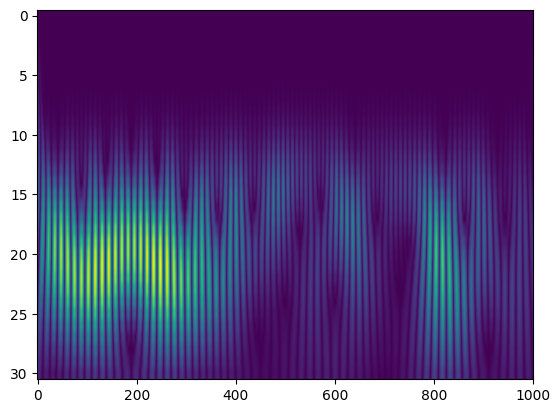

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Set wavelet parameters
wavelet = 'morl'
scales = np.arange(1, 32)

# Compute scalogram
coeffs, freqs = pywt.cwt(data[73], scales, wavelet)
plt.imshow(np.abs(coeffs[:,18,:]), cmap='viridis', aspect='auto')

In [22]:
labels = np.array(labels)

In [23]:
label=to_categorical(labels)

In [24]:
label.shape

(287, 4)

In [25]:
from sklearn.model_selection  import train_test_split


In [26]:
x_train,x_test ,y_train,y_test = train_test_split(X_tr,label,test_size = 0.25 , random_state =42 , shuffle = True,stratify = label )

In [27]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import regularizers
from keras.layers import BatchNormalization, Activation,DepthwiseConv2D,SeparableConv2D


model = Sequential()
model.add(Conv2D(8, (1, 64), padding='same', input_shape=(22, 31, 1001)))
model.add(Conv2D(8, (1, 64), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(DepthwiseConv2D((22, 1), use_bias=False, depth_multiplier=2))
model.add(BatchNormalization())
model.add(Conv2D(16, (1, 1), padding='valid', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 4)))
model.add(Dropout(0.5))

model.add(SeparableConv2D(16, (1, 16), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 4)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
model.add(Dropout(0.5))
model.add(Dense(4, activation='sigmoid'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
cv = ShuffleSplit(n_splits = 8, test_size = 0.25, random_state = 42)

In [29]:
accuracy = []
loss = []

In [30]:
for train_idx, test_idx in cv.split(labels):
    y_train, y_test = label[train_idx], label[test_idx]
    x_train,x_test =  X_tr[train_idx],X_tr[test_idx]
    st= MinMaxScaler()
    x_train = minmax(x_train,True,st)
    x_test = minmax(x_test,False,st)
    model.fit(x_train,y_train,validation_data= (x_test,y_test),epochs =15,batch_size =48)
    h= model.evaluate(x_test,y_test)
    accuracy.append(h[1])
    loss.append(h[0])

Epoch 1/15


2023-05-04 20:09:58.770230: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


5/5 [==============================] - 11s 466ms/step - loss: 3.1013 - accuracy: 0.2372 - val_loss: 2.8016 - val_accuracy: 0.3333
Epoch 2/15
5/5 [==============================] - 1s 178ms/step - loss: 3.0062 - accuracy: 0.2140 - val_loss: 2.7208 - val_accuracy: 0.2500
Epoch 3/15
5/5 [==============================] - 1s 167ms/step - loss: 2.8439 - accuracy: 0.2651 - val_loss: 2.7197 - val_accuracy: 0.2222
Epoch 4/15
5/5 [==============================] - 1s 192ms/step - loss: 2.7709 - accuracy: 0.2326 - val_loss: 2.6738 - val_accuracy: 0.2222
Epoch 5/15
5/5 [==============================] - 1s 169ms/step - loss: 2.7378 - accuracy: 0.2698 - val_loss: 2.6026 - val_accuracy: 0.2083
Epoch 6/15
5/5 [==============================] - 1s 171ms/step - loss: 2.6634 - accuracy: 0.2093 - val_loss: 2.5315 - val_accuracy: 0.2222
Epoch 7/15
5/5 [==============================] - 1s 165ms/step - loss: 2.5158 - accuracy: 0.3023 - val_loss: 2.4715 - val_accuracy: 0.2222
Epoch 8/15
5/5 [==============

In [31]:
loss

[2.117809534072876,
 1.8910342454910278,
 1.8456416130065918,
 2.717550277709961,
 3.2052793502807617,
 5.235962390899658,
 8.358506202697754,
 7.760445594787598]

In [32]:
accuracy

[0.2083333283662796,
 0.2777777910232544,
 0.2916666567325592,
 0.2361111044883728,
 0.25,
 0.4444444477558136,
 0.5277777910232544,
 0.4722222089767456]